In [1]:
using Distributions, Plots, Statistics, LinearAlgebra, DataFrames, Random, StatsModels
using StatsFuns: logistic, logit
import CSV, StatsBase

Random.seed!(12312)

TaskLocalRNG()

First generate the true parameters

In [2]:
x = CSV.File("/Users/bernardo/Documents/X.csv") |> DataFrame |> Matrix
x = x[:,2:end] #remove the first column excell put
x = x[:, Not(1:5)]
x[:,1] = rand(Bernoulli(0.7), size(x,1))
x = x[:, Not(2:(end-34))] #remove the covariates
n,p = size(x)

### median
    true_β_5 = [rand(MvNormal(zeros(p-34), I)) rand(MvNormal(repeat([2],p-34), I)) rand(MvNormal(repeat([-2],p-34), I))]#i need to create the random effects. After this is just simulating the ys from a Bernoulli
    #this yealds the random effects
    true_β_5 = [true_β_5[:,i] for i in 1:3]
    ψ = rand(Normal(), 34)
    for i in 1:3
        true_β_5[i] = vcat(true_β_5[i], ψ)
    end
### q25
true_β_25 = [rand(MvNormal(zeros(p - 34), I)) rand(MvNormal(repeat([2], p - 34), I)) rand(MvNormal(repeat([-2], p - 34), I))]#i need to create the random effects. After this is just simulating the ys from a Bernoulli
#this yealds the random effects
true_β_25 = [true_β_25[:, i] for i in 1:3]
ψ = rand(Normal(), 34)
for i in 1:3
    true_β_25[i] = vcat(true_β_25[i], ψ)
end

### q75
true_β_75 = [rand(MvNormal(zeros(p - 34), I)) rand(MvNormal(repeat([2], p - 34), I)) rand(MvNormal(repeat([-2], p - 34), I))]#i need to create the random effects. After this is just simulating the ys from a Bernoulli
#this yealds the random effects
true_β_75 = [true_β_75[:, i] for i in 1:3]
ψ = rand(Normal(), 34)
for i in 1:3
    true_β_75[i] = vcat(true_β_75[i], ψ)
end

Try instead generating an effect from a Weibull regression

In [2]:
dat = (i = string.(1:60), x1=rand(Normal(5, 1), 60),#one continuous
    x2= string.(rand(Bernoulli(0.7), 60)), #one discrete
    rf=vcat([["$i", "$i"] for i in 1:30]...) #random effects (29)
)

ts = apply_schema(term.((1, :x1, :x2, :rf)), schema(dat))

X = modelcols(MatrixTerm(ts), dat)
X = hcat(I, X[:,2:end])

60×91 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱       ⋮                        ⋮
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    

In [3]:

β_true = hcat(vcat(ones(60), [0.4, 0.2]), vcat(ones(60), [0.7, 0.5] ))
γ = rand(Uniform(-0.2,0.2), 29)
β_true = vcat(β_true, repeat(γ, inner=(1,2)))

ε = rand(Exponential(1), (60,30)) #b_new = a^-b

k = sample(1:2, 60)


y = hcat([exp.(X[i,:] ⋅ β_true[:, k[i]]) .* ε[i,:] for i in 1:size(X,1)]...)'
#y_true = exp.(X * β_true[:,k]) 

#true_eff = hcat([quantile.(x, [0.25, 0.5, 0.75]) for x in dist]...)'
#N = StatsBase.sample(10:50, 60)


60×30 adjoint(::Matrix{Float64}) with eltype Float64:
   0.389472   25.5923     0.0537504  …   13.9942      3.68984   13.4135
  14.0551      3.38393   35.9809         68.2344      6.37637   13.2792
  13.4977      5.43255   51.2415         16.3859     13.5532    41.7458
  16.5101     37.9016    15.7251          1.00429     9.13738   47.9622
   2.0466    193.021      7.25169        64.8296     12.1297    26.062
  29.9809     22.4922    22.9948     …   12.437       8.349     19.7007
  18.6042     21.7179    13.8812         42.0148     29.3991     5.74463
  24.8131     34.4291     1.62808        26.493      12.9698    23.6278
  12.8153     26.3717     0.435162        0.150668    4.69339    3.25162
  92.1854     91.7337   149.251           2.1593     39.0732   105.231
   ⋮                                 ⋱                         
   7.47709     3.56224    3.0687          5.08093    27.3087    37.6381
  20.9307     16.2982    43.6716         40.8212     28.2207    57.5254
  14.3664      1.2

Plot the hazards (without the rf)

In [21]:
survs_1 = [t -> exp(-t * exp(- x ⋅ β_true[:,1] )) for x in eachrow(X[ k .== 1, :]) ] 
survs_2 = [t -> exp(-t * exp(-x ⋅ β_true[:, 2])) for x in eachrow(X[k.==2, :])]

plot(survs_1, color = "seagreen", alpha = 0.3, label="")
plot!(survs_2, color="firebrick", alpha=0.3, label="")

savefig("~/Documents/Code/Polya_tree/surv_sim.png")


#plot( exp.(-X[k .== 1,:] * β_true[:,1] ))

"/Users/bernardo/Documents/Code/Polya_tree/surv_sim.png"

Get the observerd quantiles

In [4]:
med_obs = [quantile(yi, 0.5) for yi in eachrow(y)]
q_25_obs = [quantile(yi, 0.25) for yi in eachrow(y)]
q_75_obs = [quantile(yi, 0.75) for yi in eachrow(y)]

60-element Vector{Float64}:
  20.118704397428516
  33.02199301066085
  33.376710733384115
  36.338110776847756
  73.14549693816573
  25.2607284539126
  28.840609629713775
  61.95153786764803
  15.74462651068436
 147.23425783408314
   ⋮
  29.648865500386403
  40.170912574717526
  64.01501606497496
  53.9153035632184
  59.90275874312288
 226.88414198232599
  54.08735375988552
  30.566859542198976
   9.457322436844168

Now let's get the true quantiles

In [5]:
medians = [-log(0.5) * exp(X[i, :] ⋅ β_true[:, k[i]]) for i in 1:size(X, 1)]
q_25 = [-log(0.75) * exp(X[i, :] ⋅ β_true[:, k[i]]) for i in 1:size(X, 1)]
q_75 = [-log(0.25) * exp(X[i, :] ⋅ β_true[:, k[i]]) for i in 1:size(X, 1)]

60-element Vector{Float64}:
  22.93798821855154
  26.732784491069634
  31.880578723620744
  46.90240219114269
 143.7557140162411
  20.687966985386478
  36.68647577749344
  70.06210557724138
  17.07143303514248
 192.90579338505287
   ⋮
  27.974362779512102
  48.536288066385275
  78.22137170114284
  47.37235993262629
  62.828298328242994
 304.86040807315027
  59.059225919825046
  42.13364118191793
  16.291589338237902

In [6]:
include("/Users/bernardo/Documents/Code/Polya_tree/ddp_gibbs.jl")
include("/Users/bernardo/Documents/Code/Polya_tree/tree_struc.jl")


plot_tree (generic function with 1 method)

El problema es que el trial no cambia porque está inbuild en la matriz diseño, por ende el número de betas que generé antes no es consistente pues estas incluyen sólo un número específico que no coincide con la X.

Aunque al final esto no debería de importar para el gibbs sampler porque no las uso allí.

In [10]:
cdf.(InverseGaussian.(med_obs, 1), med_obs)

60-element Vector{Float64}:
 0.8267548570210732
 0.8462735152641068
 0.8731898726845724
 0.8500288277370412
 0.8985949988088369
 0.8427570701966735
 0.8651283394651827
 0.8778816541129804
 0.8040555768543689
 0.925731079957526
 ⋮
 0.8511987168363684
 0.8578003003510994
 0.8865013479504642
 0.8806644052183438
 0.8633733364537713
 0.939355464511544
 0.880745458218394
 0.8310502381735295
 0.7776386942007398

In [7]:
#el problema es que al final esta bio. The last one is p_r
μ_0 = vcat(logit.(cdf.(InverseGaussian.(med_obs, 1), med_obs)), zeros(size(X, 2) - 60))
N = repeat([30], size(X,1))
trial = parse.(Int64, dat[:rf])
ch_5 = gibbs_sampler(50000, N .÷ 2, X, 29, 6, N, μ_0, 1, 1, 1, 1, trial)

Dict{String, Array} with 3 entries:
  "ψ"  => [1.0, 0.559134, 1.85311, 0.430099, 1.64299, 0.757164, 2.04464, 0.4730…
  "sn" => [2 1 … 2 2; 2 3 … 2 2; … ; 2 5 … 2 2; 4 3 … 2 2]
  "β"  => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0…

Now i need to create a function that gives me the pairs (iteration, prob).

In [ ]:
#this gives the chain for the medians. estimate the other ones as well

In [8]:
μ_0 = vcat(logit.(cdf.(InverseGaussian.(med_obs, 1), q_25_obs)), zeros(size(X, 2) - 60))
ch_25 = gibbs_sampler(50000, N .÷  4, X, 29, 6, N .÷ 2, μ_0, 1, 1, 1, 1, trial)

Dict{String, Array} with 3 entries:
  "ψ"  => [1.0, 1.64168, 0.69003, 1.59786, 0.740716, 1.52851, 0.747079, 1.04005…
  "sn" => [6 5 … 1 1; 6 6 … 1 1; … ; 2 5 … 5 5; 1 1 … 6 6]
  "β"  => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0…

In [9]:
μ_0 = vcat(logit.(cdf.(InverseGaussian.(med_obs, 1), q_75_obs .- med_obs)), zeros(size(X, 2) - 60))
ch_75 = gibbs_sampler(50000, N .÷ 4, X, 29, 6, N .÷ 2, μ_0, 1, 1, 1, 1, trial)

Dict{String, Array} with 3 entries:
  "ψ"  => [1.0, 2.00959, 0.559353, 1.92042, 0.7932, 1.19873, 0.846586, 2.01552,…
  "sn" => [2 1 … 4 4; 2 1 … 5 5; … ; 6 3 … 1 1; 1 2 … 3 3]
  "β"  => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0…

In [10]:
function probs_trace(chains, X, trial, burnin)
    #for each row
    probs = zeros(size(X, 1), size(chains["β"], 3))
    for i in 1:size(X, 1)
        #for each iteration of the chain
        probs_i = zeros(size(chains["β"], 3))
        for j in burnin:size(chains["β"], 3)
            #β = (p,m,niter), sn=(n,niter)
            #Get the betas from the cluster that at each iteration the obs belongs to
            probs_i[j] = logistic.(chains["β"][:, chains["sn"][trial[i], j], j] ⋅ X[i, :])
        end
        probs[i, :] = cumsum(probs_i) ./ collect(1:length(probs_i))
    end
    return probs
end

probs_trace (generic function with 1 method)

In [11]:
tr_p_5 = probs_trace(ch_5, X, trial, 40000)
tr_p_25 = probs_trace(ch_25, X, trial, 40000)
tr_p_75 = probs_trace(ch_75, X, trial, 40000)

60×50000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0135224  0.0135244  0.0135245
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0133112  0.0133109  0.0133107
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0125385  0.0125382  0.012538
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0135873  0.013587   0.0135867
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0126225  0.0126222  0.012622
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0133606  0.0133603  0.0133601
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0134342  0.013434   0.0134337
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0134661  0.0134659  0.0134656
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0132107  0.0132104  0.0132101
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0122253  0.012225   0.0122248
 ⋮                        ⋮              ⋱                        
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0127314  0.0127311  0.0127309
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0128204  0.0128202  0.01282

In [17]:
true_p_5 = [logistic(X[i, :] ⋅ β_true[k[i]]) for i in 1:size(X, 1)]
p_hat = mapslices(mean, tr_p_5[:,49900:end], dims=2 )#trim the vector so julia doesnt cry
scatter(true_p_5, p_hat, label="")
title!("Median: fitted vs truth")
#savefig("~/Documents/Code/Polya_tree/sim_res_5.png")
#hline!([true_p[1]])
#plot([1.1,2.2,3.3], [0.1,0.2,0.5])

DimensionMismatch: DimensionMismatch: x and y are of different lengths!

In [10]:
true_p_25 = [logistic(x[i, :] ⋅ true_β_25[k[i]]) for i in 1:size(x, 1)]
p_hat = mapslices(mean, tr_p_25[:, 49900:end], dims=2)#trim the vector so julia doesnt cry
scatter(true_p_25, p_hat, label="")
title!("Q25: fitted vs truth")
savefig("~/Documents/Code/Polya_tree/sim_res_25.png")

"/Users/bernardo/Documents/Code/Polya_tree/sim_res_25.png"

In [11]:
true_p_75 = [logistic(x[i, :] ⋅ true_β_75[k[i]]) for i in 1:size(x, 1)]
p_hat = mapslices(mean, tr_p_75[:, 49900:end], dims=2)#trim the vector so julia doesnt cry
scatter(true_p_75, p_hat, label="")
title!("Q75: fitted vs truth")
savefig("~/Documents/Code/Polya_tree/sim_res_75.png")

"/Users/bernardo/Documents/Code/Polya_tree/sim_res_75.png"

Now get the estimations of effect size

In [12]:
function grow_trees(nlevels, splits, probs, c)
    nlevels ≥ 3 || throw(BoundsError("nlevels must be at least 3!"))
    #instansiate trees

    ## Create trees for each thing
    forest = Matrix{Tree}(undef, 200, size(splits, 1))
    for i in 1:size(forest, 2)
        for j in 1:size(forest, 1)
            forest[j, i] = Tree(probs[i, :], splits[i, :])
        end
    end
    # forest = [Tree(inter -> area_prob(curvas[i], points, α₀, α₁, inter), collect(select(x[i,:], :low, :median, :hi))) for i in 1:nrow(x)]
    for i in ProgressBar(2:nlevels)
        #levels are horizontal, trees vertical
        #probs = [area_prob(xi, j, i, α₀, α₁, αₘ, sigma) for j in nodes_in_level, xi in x]
        #probs = hcat(probs...)
        for k in 1:200
            for tree in forest[k, :]
                nodes_in_level = findall(x -> x.level == i - 1, tree.nodes)  #find all the nodes to split
                for j in nodes_in_level
                    #y = area_prob(curvas[tree], points, α₀, α₁, [inter[1], mean(inter)]) # <- add the interval here
                    split_node!(tree, j, rand(Beta(c * 2.0^i, c * 2.0^i)), InverseGaussian())
                end
            end
        end
    end

    return forest
end


grow_trees (generic function with 1 method)

First get the estimated probabilities

In [19]:
bosque = grow_trees(9, X[:, [3, 4, 5, 2]], probs, 2)
import Statistics.median
median_bosque = mapslices(median_tree, bosque, dims=1)
medians = [get_quantile(bosque[1, i], 0.75) for i in 1:size(bosque, 2)]

UndefVarError: UndefVarError: `burnin` not defined

In [39]:
mean_probs = hcat(estimate_probs(ch_5, X), estimate_probs(ch_25, X))
mean_probs = hcat(mean_probs[:,2], mean_probs)

60×3 Matrix{Float64}:
 0.327691  1.0  0.327691
 0.235715  1.0  0.235715
 0.33035   1.0  0.33035
 0.357611  1.0  0.357611
 0.237301  1.0  0.237301
 0.288565  1.0  0.288565
 0.304061  1.0  0.304061
 0.269134  1.0  0.269134
 0.291613  1.0  0.291613
 0.266364  1.0  0.266364
 ⋮              
 0.255948  1.0  0.255948
 0.357418  1.0  0.357418
 0.290748  1.0  0.290748
 0.260907  1.0  0.260907
 0.292994  1.0  0.292994
 0.350268  1.0  0.350268
 0.395262  1.0  0.395262
 0.239232  1.0  0.239232
 0.318062  1.0  0.318062

0.0%┣                                                ┫ 0/8 [00:00<00:00, -0s/it]


12.5%┣█████▍                                     ┫ 1/8 [00:00<Inf:Inf, InfGs/it]


25.0%┣████████████                                    ┫ 2/8 [00:00<00:02, 3it/s]


37.5%┣██████████████████                              ┫ 3/8 [00:00<00:01, 4it/s]


50.0%┣████████████████████████                        ┫ 4/8 [00:01<00:01, 3it/s]


62.5%┣██████████████████████████████                  ┫ 5/8 [00:02<00:01, 2it/s]


75.0%┣████████████████████████████████████            ┫ 6/8 [00:03<00:01, 2it/s]


87.5%┣██████████████████████████████████████████      ┫ 7/8 [00:06<00:01, 1s/it]


100.0%┣███████████████████████████████████████████████┫ 8/8 [00:13<00:00, 2s/it]
100.0%┣███████████████████████████████████████████████┫ 8/8 [00:13<00:00, 2s/it]


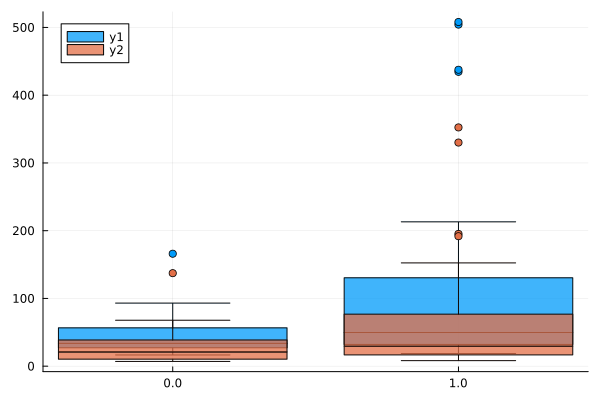

In [13]:
mean_probs = hcat(tr_p_25[:,end], tr_p_5[:,end], tr_p_75[:,end])
cuts = hcat(q_25_obs, med_obs, q_75_obs, N)
bosque = grow_trees(9, cuts, mean_probs, 1)
import Statistics.median
median_bosque = mapslices(median_tree, bosque, dims=1)
medians_est = [get_quantile(bosque[1, i], 0.5) for i in 1:size(bosque, 2)]

#do tapply(medians, bio, mean)
#X[:,7] is bio
using StatsPlots
bio = string.(X[:, 62])
bio[bio.=="1"] .= "Bio +"
bio[bio.=="0"] .= "Bio -"
boxplot(bio, medians_est, fillalpha=0.75)
boxplot!(bio, medians, fillalpha=0.75)
#savefig("~/Documents/Code/Polya_tree/medians_boxplots.png")

In [20]:
boxplot(bio, medians, fillalpha=0.75, label="Truth")
boxplot!(bio, medians_est, fillalpha=0.75, label="Estimated")
savefig("~/Documents/Code/Polya_tree/boxplots_sym.png")

"/Users/bernardo/Documents/Code/Polya_tree/boxplots_sym.png"